In [4]:
import sys
sys.path[0] = ('/home/labs/waic/omrik/DNN-Challenge')
from fastai.vision import *
import pre
import resample
from metrics import Pearson

root = Path('../data').resolve()
train = root / 'train'
val = root / 'val'

In [19]:
def normalize_time(series):
    # 1440 minutes in a day
    normalized = (series.hour * 60 + series.minute) / 1440
    return normalized

def get_data(data_dir):
    cgm, meals = pre.get_dfs(data_dir)
    meals = resample.resample_meals(cgm, meals, 15)
    meals = pd.concat((meals, cgm), axis=1)
    meals['time'] = normalize_time(meals.index.get_level_values('Date'))
    cgm, y = pre.build_cgm(cgm, drop=True)
    return cgm, meals, y

class ContData(Dataset):
    def __init__(self, cgm, meals, y):
#         self.cgm = cgm.loc[y.index].dropna(how='any', axis=0)
        self.cgm = cgm
        self.meals = meals
        self.y = y
        
    def __len__(self):
        return len(self.cgm)
    
    def __getitem__(self, i):
        index = self.meals.index.get_loc(self.cgm.index[i])
        values = self.meals[index-48:index+1].values
        target = self.y.iloc[i].values
        x, y = torch.tensor(values, dtype=torch.float), torch.tensor(target, dtype=torch.float)
        return x, y


In [8]:
train_data = get_data(train)
val_data = get_data(val)
train_data[1].head()

/home/labs/waic/omrik/DNN-Challenge/pre.py:74: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  X = X.loc[y.index].dropna(how='any', axis=0)


weight  alanine_g  alcohol_g  arginine_g  caffeine_mg  \
id Date                                                                         
46 2015-01-05 10:18:00     0.0        0.0        0.0         0.0          0.0   
   2015-01-05 10:33:00     0.0        0.0        0.0         0.0          0.0   
   2015-01-05 10:48:00     0.0        0.0        0.0         0.0          0.0   
   2015-01-05 11:03:00     0.0        0.0        0.0         0.0          0.0   
   2015-01-05 11:18:00     0.0        0.0        0.0         0.0          0.0   

                        calcium_mg  carbohydrate_g  cholesterol_mg  \
id Date                                                              
46 2015-01-05 10:18:00         0.0             0.0             0.0   
   2015-01-05 10:33:00         0.0             0.0             0.0   
   2015-01-05 10:48:00         0.0             0.0             0.0   
   2015-01-05 11:03:00         0.0             0.0             0.0   
   2015-01-05 11:18:00         0.0             0.0             0.0   

                        energy_kcal  fructose_g  ...  \
id Date                                          ...   
46 2015-01-05 10:18:00          0.0         0.0  ...   
   2015-01-05 10:33:00          0.0         0.0  ...   
   2015-01-05 10:48:00          0.0         0.0  ...   
   2015-01-05 11:03:00          0.0         0.0  ...   
   2015-01-05 11:18:00          0.0         0.0  ...   

                        totalpolyunsaturatedfattyacids_g  \
id Date                                                    
46 2015-01-05 10:18:00                               0.0   
   2015-01-05 10:33:00                               0.0   
   2015-01-05 10:48:00                               0.0   
   2015-01-05 11:03:00                               0.0   
   2015-01-05 11:18:00                               0.0   

                        totalsaturatedfattyacids_g  totaltransfattyacids_g  \
id Date                                                                      
46 2015-01-05 10:18:00                         0.0                     0.0   
   2015-01-05 10:33:00                         0.0                     0.0   
   2015-01-05 10:48:00                         0.0                     0.0   
   2015-01-05 11:03:00                         0.0                     0.0   
   2015-01-05 11:18:00                         0.0                     0.0   

                        vitaminc_mg  vitamind_iu  vitamine_mg  water_g  \
id Date                                                                  
46 2015-01-05 10:18:00          0.0          0.0          0.0      0.0   
   2015-01-05 10:33:00          0.0          0.0          0.0      0.0   
   2015-01-05 10:48:00          0.0          0.0          0.0      0.0   
   2015-01-05 11:03:00          0.0          0.0          0.0      0.0   
   2015-01-05 11:18:00          0.0          0.0          0.0      0.0   

                        zinc_mg  GlucoseValue      time  
id Date                                                  
46 2015-01-05 10:18:00      0.0      6.647964  0.429167  
   2015-01-05 10:33:00      0.0      6.465828  0.439583  
   2015-01-05 10:48:00      0.0      6.101556  0.450000  
   2015-01-05 11:03:00      0.0      6.010488  0.460417  
   2015-01-05 11:18:00      0.0      6.192624  0.470833  

[5 rows x 38 columns]

In [20]:
train_ds = ContData(*train_data)
val_ds = ContData(*val_data)
data = DataBunch.create(train_ds, val_ds, bs=512)
data

DataBunch;

Train: <__main__.ContData object at 0x7f5b926f9e48>;

Valid: <__main__.ContData object at 0x7f5b926f9ef0>;

Test: None

In [21]:
class WindowPearson(Pearson):
    def __init__(self, gt):
        super().__init__(gt)
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        super().on_batch_end(last_output[-1], last_target, **kwargs)
        
p = WindowPearson(val_ds.y)

def loss(outputs, targets):
    targets = targets[None].expand_as(outputs)
    return F.mse_loss(outputs, targets)


In [29]:
def generate_square_subsequent_mask(sz):
    r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
        Unmasked positions are filled with float(0.0).
    """
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

class TransformerModel(Module):
    def __init__(self, d_model, nhead, nlayers, dim_feedforward=2048, dropout=0.1, decoder=None):
        super().__init__()
        self.encoder = nn.Linear(38, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        
        if decoder is None:
            decoder = nn.Linear(d_model, 8)
        self.decoder = decoder
        self.d_model = d_model
        
    def forward(self, src):
        src = src.transpose(0, 1)
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        mask = generate_square_subsequent_mask(len(src)).to(src.device)
        output = self.transformer_encoder(src, mask=mask)
        output = self.decoder(output)
        return output
            

In [30]:
model = TransformerModel(128, 2, 2, dim_feedforward=256)
learner = Learner(data, model, loss_func=loss, metrics=p)

epoch,train_loss,valid_loss,window_pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-05
Min loss divided by 10: 4.79E-03


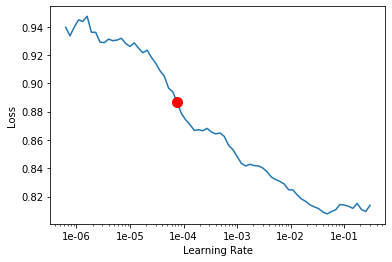

In [31]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [32]:
learner.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,window_pearson,time
0,0.711789,0.684439,0.363908,09:18
1,0.686315,0.666260,0.572552,09:01
2,0.679418,0.663631,0.579430,08:37
3,0.692638,0.662587,0.594267,08:16
4,0.688156,0.661741,0.597944,08:11


In [ ]:
def get_data(data_dir):
    cgm, meals = pre.get_dfs(data_dir)
    meals = resample.resample_meals(cgm, meals, 15)
    meals = pd.concat((meals, cgm), axis=1)
    meals['time'] = normalize_time(meals.index.get_level_values('Date'))
    cgm, y = pre.build_cgm(cgm, drop=False)
    return cgm, meals, y

class ContData(Dataset):
    def __init__(self, cgm, meals, y):
        self.cgm = cgm.loc[y.index].dropna(how='any', axis=0)
        self.meals = meals
        self.y = y
        
    def __len__(self):
        return len(self.cgm)
    
    def __getitem__(self, i):
        index = self.meals.index.get_loc(self.cgm.index[i])
        values = self.meals[index-48:index+1].values
        index = self.y.index.get_loc(self.cgm.index[i])
        target = self.y.iloc[index-48:index+1]
        assert len(target.index.get_level_values(0).unique()) == 1
        x, y = torch.tensor(values, dtype=torch.float), torch.tensor(target.values, dtype=torch.float)
        return x, y
    
def loss(outputs, targets):
    targets = targets.transpose(0, 1)
    return F.mse_loss(outputs, targets)

In [34]:
train_data = get_data(train)
val_data = get_data(val)

In [51]:
train_ds = ContData(*train_data)
val_ds = ContData(*val_data)
data = DataBunch.create(train_ds, val_ds, bs=512)
data

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


DataBunch;

Train: <__main__.ContData object at 0x7f5c39a9b400>;

Valid: <__main__.ContData object at 0x7f5b920e2a20>;

Test: None

epoch,train_loss,valid_loss,window_pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-05
Min loss divided by 10: 6.92E-03


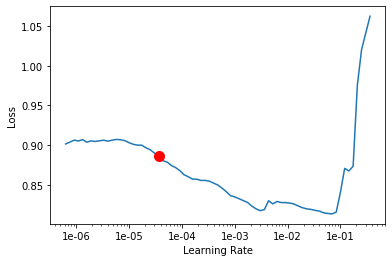

In [53]:
model = TransformerModel(128, 2, 2, dim_feedforward=256)
learner = Learner(data, model, loss_func=loss, metrics=p)
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [54]:
learner.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,window_pearson,time
0,0.495265,0.483301,0.593541,12:46
1,0.471061,0.464152,0.604400,12:44
2,0.459313,0.459915,0.611374,12:45
3,0.453387,0.458477,0.614489,12:50
4,0.452424,0.457104,0.614133,12:50


In [55]:
learner.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,window_pearson,time
0,0.454050,0.457156,0.614972,12:48
1,0.449579,0.456576,0.613559,12:45
2,0.447171,0.458546,0.614778,12:50


KeyboardInterrupt: 

epoch,train_loss,valid_loss,window_pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-01
Min loss divided by 10: 4.37E-04


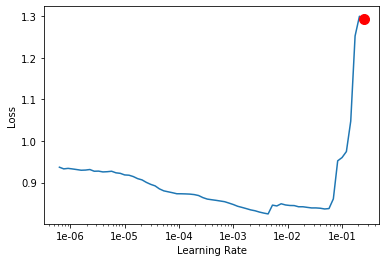

In [56]:
model = TransformerModel(200, 2, 4, dim_feedforward=200)
learner = Learner(data, model, loss_func=loss, metrics=p)
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
learner.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,window_pearson,time
0,0.506591,0.492775,0.589162,13:00
1,0.476531,0.466122,0.607036,12:59
2,0.458346,0.456407,0.616469,13:01
3,0.449729,0.451977,0.615313,13:02
4,0.439240,0.464938,0.610811,13:01
5,0.431035,0.470783,0.608436,13:01
6,0.417131,0.479687,0.608167,13:04
7,0.409273,0.478545,0.600324,12:57
8,0.401728,0.484125,0.596517,12:52
9,0.391820,0.487525,0.592924,12:54
